+ [x] video to image
+ [x] image to text

In [5]:
import cv2
from os import listdir
from google.cloud import vision
import os
import io
from datetime import datetime, timedelta
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./vision API-06a448b64428.json"

## Video to image

In [3]:
vidcap = cv2.VideoCapture('RPReplay_Final_01.mp4')

In [6]:
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        if len(str(count)) ==2:
            cv2.imwrite("./image/image"+'0'+str(count)+".jpg", image)     # save frame as JPG file
        else:
            cv2.imwrite("./image/image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 3      #//it will capture image in each 3 second
count=1
success = getFrame(sec)


In [7]:
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

## image to text

In [255]:
# 파일명 가져오기
directory_name = "./image"
file_names = listdir(directory_name)

In [4]:
# 이미지 파일 겟수
len(file_names)

346

In [5]:
file_names[0]

'image001.jpg'

In [6]:
# 전체 자료 불러오기 & 병합
# for open_file in file_names:
#     df_temp = pd.read_excel('./data/' + open_file,'Sheet1')
#     ORDER = pd.concat([ORDER, df_temp], ignore_index=False)

In [128]:
''' image to text(list) '''
from google.cloud import vision
client = vision.ImageAnnotatorClient()

text = []
x_0 = []
x_1 = []
y_0 = []

for fine_name in file_names:
    path = './image/'+ fine_name

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    start_x, start_y = word.bounding_box.vertices[0].x , word.bounding_box.vertices[0].y 
                    start_x2 = word.bounding_box.vertices[2].x
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    if  1518 > start_y > 1180:
                        text.append(word_text)
                        x_0.append(start_x)
                        x_1.append(start_x2)
                        y_0.append(start_y)
    #                     print('{}\t{}\t{}\t{}'.format(word_text, start_x, start_x2, start_y) )

''' text(list) to dataframe '''

import pandas as pd 

df = pd.DataFrame()
df['text'] = text
df['x0'] = x_0
df['x1'] = x_1
df['y0'] = y_0


In [310]:
## v2
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

# path = './image/'+ file_names[-25]

# API를 통한 text 인식정보 저장
from google.cloud import vision
client = vision.ImageAnnotatorClient()

df = pd.DataFrame()

for file_name in file_names:
    path = './image/'+ file_name
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    df0 = response.text_annotations[0].description
    df0 = df0.replace('\n', ',').split(",")

    df1 = pd.DataFrame()
    df1['text'] = df0[7:-5]
    df1['time'] = df0[0]
    df1[['user','text_gubun']] = df1["text"].str.split(" ", 1, expand=True)
    
    df = pd.concat([df, df1], axis=0, ignore_index=True)


In [306]:
df

,text,time,user,text_gubun
0,잠시 후 12시부터 LG생활건강 전제춤 판매,8:28,잠시,후 12시부터 LG생활건강 전제춤 판매
1,"시작 "" (마스크까지 있어요 대박 @)",8:28,시작,""" (마스크까지 있어요 대박 @)"
2,잠시 후 12시부터 LG생활건강 전제춤 판매,.ll,잠시,후 12시부터 LG생활건강 전제춤 판매
3,"시작 "" (마스크까지 있어요 대박 )",.ll,시작,""" (마스크까지 있어요 대박 )"
4,beanbean 아몬드는 어때요???,8:28,beanbean,아몬드는 어때요???
...,...,...,...,...
64,칭찬해주세요 안녕하세요.,8:29,칭찬해주세요,안녕하세요.
65,용경애 안녕하세여,8:29,용경애,안녕하세여
66,그루브타는 JIN 안녕하세요^^,8:29,그루브타는,JIN 안녕하세요^^
67,하뇽이 그립으로 넘어왔어요~~◇ㅇ,8:29,하뇽이,그립으로 넘어왔어요~~◇ㅇ


In [311]:
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_grip_data.xlsx'
df.to_excel(excel_name, sheet_name= 'Sheet1' )

In [130]:
df['text_bias'] = 0 
df['text_gubun'] =''
df['text_gubun'][0] = df['text'][0]

for i in range(1, len(df['y0'])):
    if df['y0'][i-1]-2 < df['y0'][i] < df['y0'][i-1]+2:
        df['text_bias'][i] = df['x0'][i] - df['x1'][i-1]
        if df['text_bias'][i] < 12:
            df['text_gubun'][i] = df['text_gubun'][i-1] + df['text'][i]
            df['text_gubun'][i-1] = ''
        else:
            df['text_gubun'][i] = df['text_gubun'][i-1] +' '+ df['text'][i]
            df['text_gubun'][i-1] = ''
    else:
        df['text_gubun'][i] = df['text'][i]
#         df['text_gubun'][i] = ''


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sy

In [131]:
df2 = df['text_gubun'].drop_duplicates()

In [132]:
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_grip_data.xlsx'
df2.to_excel(excel_name, sheet_name= 'Sheet1' )

In [8]:
def detect_text(path):
    """Detects text in the file."""

    # 이미지 정보 저장
    img1 = cv2.imread(path)
    b, g, r = cv2.split(img1)   # img파일을 b,g,r로 분리
    img1 = cv2.merge([r,g,b])   # b, r을 바꿔서 Merge
    height, width, channels = img1.shape

    # API를 통한 text 인식정보 저장
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    # [START vision_python_migration_text_detection]
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)

    for text_ in response.text_annotations:
        start_x = text_.bounding_poly.vertices[0].x
        start_y = text_.bounding_poly.vertices[0].y
        end_x   = text_.bounding_poly.vertices[2].x
        end_y   = text_.bounding_poly.vertices[2].y

        img1 = cv2.rectangle(img1, 
                             (int(round(start_x,0)), int(round(start_y,0))), 
                             (int(round(end_x  ,0)), int(round(end_y  ,0))), 
                             (0,255,0), 3)
        
#         img1 = cv2.putText(img1, text_.description, (int(round(start_x,0)), int(round(start_y,0))), 
#                cv2.FONT_HERSHEY_PLAIN, (width*0.002), (255, 0, 0), 2)
        
    plt.figure(figsize=(15,15))
    plt.imshow(img1)
    plt.xticks([]) # x축 눈금 미출력
    plt.yticks([]) # y축 눈금 미출력

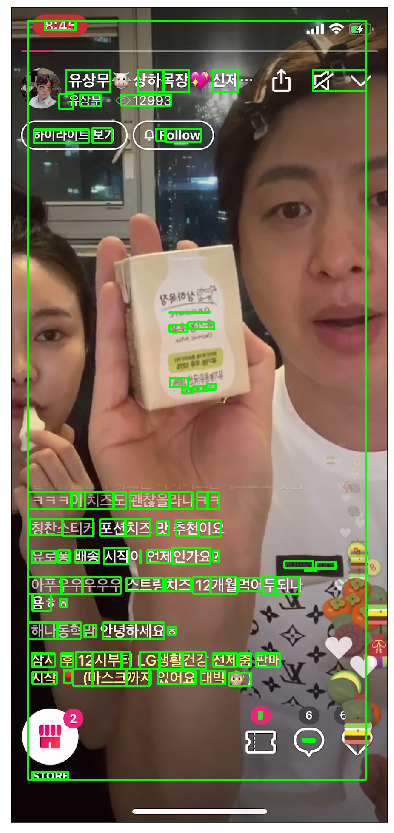

In [9]:
detect_text('./image/image332.jpg')